In [1]:
from sympy import sin, cos, symbols, diff, Matrix, lambdify
from sympy import solve, simplify
from sympy.physics.mechanics import LagrangesMethod, Lagrangian
from sympy.physics.mechanics import ReferenceFrame, Particle, Point
from sympy.physics.mechanics import dynamicsymbols, kinetic_energy
from sympy.physics.mechanics import mprint, mlatex
from sympy import init_printing, init_session
from sympy.physics.vector import init_vprinting
init_vprinting(pretty_print=True)
import numpy as np
from scipy import signal
import control
#https://qiita.com/acela86/items/170dba21021e387dfc89

# 1段振り子

一段振り子の伝達関数をラグランジアンから求める。


まずは、Sympyの準備から。振り子の変数を定義する。

In [2]:
t = symbols("t")
X, x1, f1 = dynamicsymbols("X x1 f1")
m1, c1, k1 = symbols("m1 c1 k1")
l1, g = symbols("l1 g")
w1 = symbols("w1")

質点を定義する。

In [3]:
N = ReferenceFrame("N")

p1 = Point("p1") 
v1 = x1.diff(t)
p1.set_vel(N, v1*N.x)
pa1 = Particle("pa1", p1, m1)

ポテンシャルエネルギーを定義する。

In [4]:
pa1.potential_energy = k1*(x1-X)**2/2 

外力を定義する。

In [5]:
F = c1*(v1)**2/2
fc1 = -F.diff(v1)
fl = [(p1, (f1 + fc1)*N.x)]

ラグランジアンから運動方程式を求める。

In [6]:
L = Lagrangian(N, pa1)
q = Matrix([x1])
LM = LagrangesMethod(L, q, forcelist=fl, frame=N)
eq = LM.form_lagranges_equations()
As, Bs, u = LM.linearize(q_ind=q, qd_ind=q.diff(t), A_and_B=True)#,simplify=True)
eq

⎡        k₁⋅(-2⋅X + 2⋅x₁)             ⎤
⎢c₁⋅x₁̇ + ──────────────── + m₁⋅x₁̈ - f₁⎥
⎣               2                     ⎦

実際の値を代入する。

In [7]:
m1n = 1. #kg
c1n = 0.00005 #
gn = 9.8
l1n = 0.25
w1n = (gn/l1n)**(1/2)
k1n = w1n**2*m1n

As_func = lambdify((m1, c1, k1), As, modules="numpy")
Bs_func = lambdify((m1, k1), Bs, modules="numpy")

A0 = As_func(m1n, c1n, k1n)
B0 = Bs_func(m1n, k1n)

状態方程式から伝達関数を求める。そのために、出力項を定義する。

状態変数すべてをとりだしたいので、Cは単位行列にする。
入力は出力に取り出さないのでDはゼロ。

In [8]:
C = np.eye(2)
D = np.zeros((2,2))

Python のControlパッケージをつかって、ABCD行列から求める。

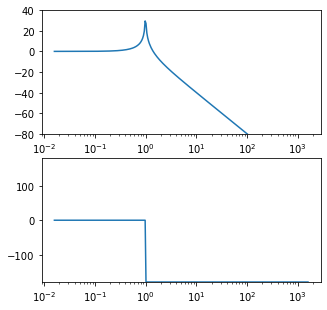

In [9]:
import matplotlib.pyplot as plt
sys = control.ss(A0,B0,C,D)
mag,phase,omega = sys.freqresp(np.logspace(-1,4,300))

_in,_out = 0,0 

fig, ax = plt.subplots(2,1,figsize=(5,5))
mag = 20*np.log10(mag[_out][_in])
phase = phase[_out][_in]
freq = omega/(2.0*np.pi)
ax[0].semilogx(freq,mag)
ax[0].set_ylim(-80,40)
ax[1].semilogx(freq, np.rad2deg(phase))  
ax[1].set_ylim(-180,180)
plt.show()

OK。

# 2段振り子

新井さん[修論](https://granite.phys.s.u-tokyo.ac.jp/theses/arai_m.pdf)を参考にして、二段振り子の伝達関数を求める。

## ダンピングなし
まず、以下のようなダンピングなしのモデルを考える。簡単のために、上段と下段の振り子は同じ質量で同じ長さの振り子とした。

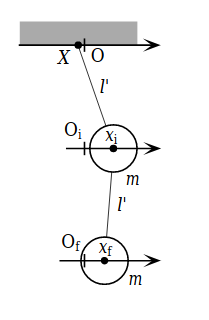
図１：ダンピングなしの二段振り子の力学モデル。新井さんの修論の図4.1を転載。

マス１の上にマス2を置く。（iを2、fを1として読み替える。）

In [10]:
# Define the valiables
x2, f2 = dynamicsymbols("x2 f2")
m2, c2, k2 = symbols("m2 c2 k2")
l2, g = symbols("l2 g")
w2 = symbols("w2")
# Define the point mass
p2 = Point("p2") 
v2 = x2.diff(t)
p2.set_vel(N, v2*N.x)
pa2 = Particle("pa2", p2, m2)
#

ポテンシャルエネルギーを再定義する。

In [11]:
pa2.potential_energy = k2*(x2-X)**2/2 + k1*(x1-x2)**2/2
pa1.potential_energy = k1*(x2-x1)**2/2

外力も再定義する。

In [12]:
F = c1*(v1)**2/2 + c2*(v2)**2/2 
fc1 = -F.diff(v1)
fc2 = -F.diff(v2)
fl = [(p1, (f1 + fc1)*N.x), (p2, (f2 + fc2)*N.x)] # with damping

運動方程式を再び求める。

In [13]:
L = Lagrangian(N, pa1, pa2)
q = Matrix([x1,x2])
LM = LagrangesMethod(L, q, forcelist=fl, frame=N)
eq = LM.form_lagranges_equations()
As, Bs, u = LM.linearize(q_ind=q, qd_ind=q.diff(t), A_and_B=True)#,simplify=True)
eq

⎡          c₁⋅x₁̇ + k₁⋅(2⋅x₁ - 2⋅x₂) + m₁⋅x₁̈ - f₁          ⎤
⎢                                                         ⎥
⎢                            k₂⋅(-2⋅X + 2⋅x₂)             ⎥
⎢c₂⋅x₂̇ + k₁⋅(-2⋅x₁ + 2⋅x₂) + ──────────────── + m₂⋅x₂̈ - f₂⎥
⎣                                   2                     ⎦

実際の値を代入し、ABCD行列を用意する。

In [14]:
m1n = 1. #kg
m2n = 1. #kg
c1n = 0.0 #
c2n = 0.0 #
l1n = 0.25
l2n = 0.5 - l1n
w1n = (gn/l1n)**(1/2)
w2n = (gn/l2n)**(1/2)
k1n = w1n**2*m1n
k2n = w2n**2*m2n

As_func = lambdify((m1, c1, k1, m2, c2, k2), As, modules="numpy")
Bs_func = lambdify((m1, k1, m2, k2), Bs, modules="numpy")

A0 = As_func(m1n, c1n, k1n, m2n, c2n, k2n)
B0 = Bs_func(m1n, k1n, m2n, k2n)

In [15]:
C = np.eye(4)
D = np.zeros((4,3))

Python のControlパッケージをつかって、ABCD行列から求める。

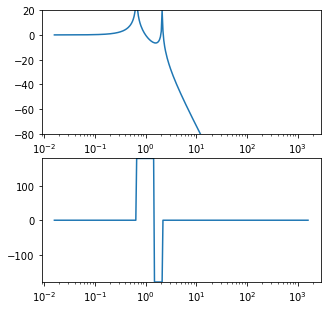

In [16]:
import matplotlib.pyplot as plt
sys = control.ss(A0,B0,C,D)
mag,phase,omega = sys.freqresp(np.logspace(-1,4,300))

_in,_out = 0,0 

fig, ax = plt.subplots(2,1,figsize=(5,5))
mag = 20*np.log10(mag[_out][_in])
phase = phase[_out][_in]
freq = omega/(2.0*np.pi)
ax[0].semilogx(freq,mag)
ax[0].set_ylim(-80,20)
ax[1].semilogx(freq, np.rad2deg(phase))  
ax[1].set_ylim(-180,180)
plt.show()

OK。

## フレキシブルダンピングあり

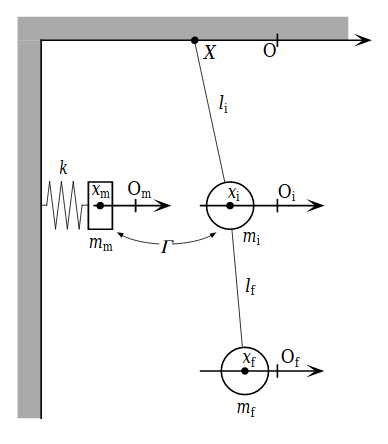

mは50に読み替える。ガンマはd0に読み替える。

In [17]:
# Define the valiables
x50, f50 = dynamicsymbols("x50 f50")
m50, c50, d0, k50 = symbols("m50 c50 d0 k50")
l50, g = symbols("l50 g")
w50 = symbols("w50")
# Define the point mass
p50 = Point("p50") 
v50 = x50.diff(t)
p50.set_vel(N, v50*N.x)
pa50 = Particle("pa50", p50, m50)
#

In [18]:
pa50.potential_energy = k50*(x50-X)**2/2
pa2.potential_energy = k2*(x2-X)**2/2 + k1*(x1-x2)**2/2
pa1.potential_energy = k1*(x2-x1)**2/2

In [19]:
F = c1*(v1)**2/2 + c2*(v2)**2/2 + c50*(v50)**2/2 + d0*(v2-v50)**2/2
fc1 = -F.diff(v1)
fc2 = -F.diff(v2)
fc50 = -F.diff(v50)
fl = [(p1, (f1 + fc1)*N.x), (p2, (f2 + fc2)*N.x), (p50, (f50 + fc50)*N.x)]

In [20]:
L = Lagrangian(N, pa1, pa2, pa50)
q = Matrix([x1,x2,x50])
LM = LagrangesMethod(L, q, forcelist=fl, frame=N)
eq = LM.form_lagranges_equations()
As, Bs, u = LM.linearize(q_ind=q, qd_ind=q.diff(t), A_and_B=True)#,simplify=True)
eq

⎡                    c₁⋅x₁̇ + k₁⋅(2⋅x₁ - 2⋅x₂) + m₁⋅x₁̈ - f₁                  
⎢                                                                             
⎢        d₀⋅(2⋅x₂̇ - 2⋅x₅̇₀)                       k₂⋅(-2⋅X + 2⋅x₂)           
⎢c₂⋅x₂̇ + ───────────────── + k₁⋅(-2⋅x₁ + 2⋅x₂) + ──────────────── + m₂⋅x₂̈ - 
⎢                2                                      2                     
⎢                                                                             
⎢                d₀⋅(-2⋅x₂̇ + 2⋅x₅̇₀)   k₅₀⋅(-2⋅X + 2⋅x₅₀)                    
⎢      c₅₀⋅x₅̇₀ + ────────────────── + ────────────────── + m₅₀⋅x₅̈₀ - f₅₀    
⎣                        2                    2                               

  ⎤
⎥
  ⎥
f₂⎥
⎥
⎥
  ⎥
  ⎥
⎦

In [21]:
m1n = 1. #kg
m2n = 1. #kg
m50n = 0.5 #kg
c1n = 0.0 #
c2n = 0.0 #
c50n = 0.0 #
d0n = 20 #
l1n = 0.25
l2n = 0.5 - l1n
w1n = (gn/l1n)**(1/2)
w2n = (gn/l2n)**(1/2)
w50n = 6*(2.0*np.pi)
k1n = w1n**2*m1n
k2n = w2n**2*m2n
k50n = w50n**2*m50n

As_func = lambdify((m1, c1, k1, m2, c2, k2, m50, k50, c50, d0), As, modules="numpy")
Bs_func = lambdify((m1, k1, m2, k2, m50, k50, c50), Bs, modules="numpy")

A0 = As_func(m1n, c1n, k1n, m2n, c2n, k2n, m50n, k50n, c50n, d0n)
B0 = Bs_func(m1n, k1n, m2n, k2n, m50n, k50n, d0n)

C = np.eye(6)
D = np.zeros((6,4))

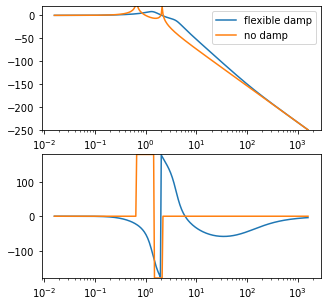

In [23]:
import matplotlib.pyplot as plt
sys_damp = control.ss(A0,B0,C,D)
mag_d,phase_d,omega_d = sys_damp.freqresp(np.logspace(-1,4,300))

_in,_out = 0,0 

fig, ax = plt.subplots(2,1,figsize=(5,5))
mag_d = 20*np.log10(mag_d[_out][_in])
phase_d = phase_d[_out][_in]
freq_d = omega_d/(2.0*np.pi)
ax[0].semilogx(freq_d,mag_d,label='flexible damp')
ax[0].semilogx(freq,mag,label='no damp')
ax[0].legend()
ax[0].set_ylim(-250,20)
ax[1].semilogx(freq_d, np.rad2deg(phase_d))  
ax[1].semilogx(freq, np.rad2deg(phase))  
ax[1].set_ylim(-180,180)

plt.show()

# 参考文献
[1] 新井修論